Todo
- Create interactive plot of gamma (with similarity threshold)
- Plot z sim function
- Use 2dhist with relative z and y dist to show loss value
(- Use 2dhist from sampling_analysis.ipynb and show for each field the loss value)
- Later: Check old values? (old normalisation: What y dist did we have?)

In [3]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [4]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from typing import Union, List, Dict
from tqdm import tqdm
import ipywidgets as widgets
import torch.nn.functional as F
torch.manual_seed(42)
torch.set_grad_enabled(False)

SIMILARITY_THRESHOLD = 1e-3

## 1. Contrastive loss functions (without actual data)

### 1.1. Old functions

In [84]:
from ipywidgets import interactive
import ipywidgets as widgets

def plot_gamma(a, b, log_x):
    logistic = lambda x: 1/(1+ torch.exp(a * x - b))
    
    x = np.logspace(-4, 0, 400)
    
    plt.figure(figsize=(6, 4))
    plt.plot(x, logistic(torch.tensor(x)), label='Logistic')
    plt.axvline(x=SIMILARITY_THRESHOLD, color='r', linestyle='--', label='Similarity threshold')
    plt.xscale('log' if log_x else 'linear')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.xlabel('MSE distance (y)')
    plt.ylabel('Gamma')
    plt.show()

interactive_plot = interactive(
    plot_gamma,
    a=widgets.FloatSlider(min=1, max=100, step=1, value=40, description='Sharpness'),
    b=widgets.FloatSlider(min=0, max=10, step=0.1, value=5, description='Shift'),
    log_x=widgets.Checkbox(value=True, description='Log x')
)
display(interactive_plot)

interactive(children=(FloatSlider(value=40.0, description='Sharpness', min=1.0, step=1.0), FloatSlider(value=5…

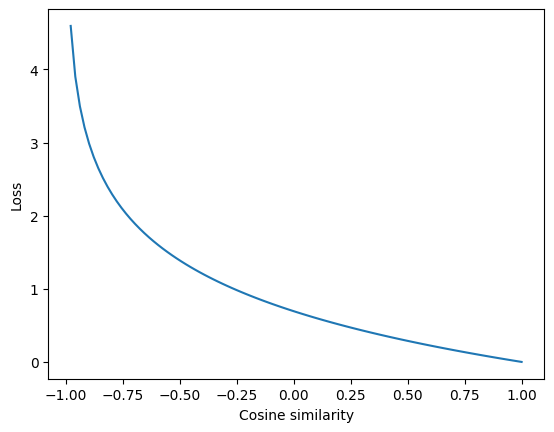

In [32]:

x = torch.linspace(-1, 1, 100)
z_dissim_loss = -torch.log((1+x)/2) 
plt.plot(x, z_dissim_loss)
plt.xlabel('Cosine similarity')
plt.ylabel('Loss')
plt.show()


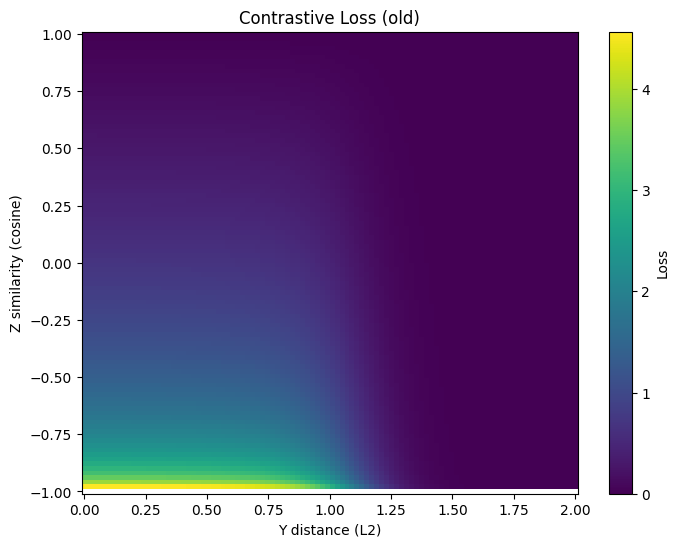

In [114]:
def contrastive_loss_old(z_sim, y_dist):
    a, b = 40, 5
    gamma_func = lambda x: 1/(1+ torch.exp(a * x - b))

    y_dist = y_dist / 3  # (old normalisation roughly resulted in range ~0.3 compared to range~1 now. y_dist now is around 1 so with old normalisation it would have been around 0.3)
    
    gamma = gamma_func(y_dist.square())  # Scaling factor: Only if graphs are similar should large z_dissim be penalized
    z_dissim_loss = -torch.log((1+z_sim)/2)  # -> 1 if different, 0 if similar, -> 2 if unrelated
    loss = gamma * z_dissim_loss
    return loss

# Create 2D histogram of contrastive loss
z_sim = torch.linspace(-1, 1, 100)
y_dist = torch.linspace(0, 2, 100)
Z, Y = torch.meshgrid(z_sim, y_dist, indexing='xy')

# Calculate loss for each point
loss_grid = contrastive_loss_old(Z, Y)

plt.figure(figsize=(8, 6))
plt.pcolormesh(Y.numpy(), Z.numpy(), loss_grid.numpy(), shading='auto')
plt.colorbar(label='Loss')
plt.ylabel('Z similarity (cosine)')
plt.xlabel('Y distance (L2)')
plt.title('Contrastive Loss (old)')
plt.show()


### 1.2. New functions 
based on latent L2 distance and new normalisation

In [89]:
from ipywidgets import interactive
import ipywidgets as widgets

def plot_gamma(a, b, log_x):
    logistic = lambda x: 1/(1+ torch.exp(a * x - b))
    threshold = lambda x: x < SIMILARITY_THRESHOLD
    
    x = np.logspace(-4, 0, 400)
    
    plt.figure(figsize=(6, 4))
    plt.plot(x, logistic(torch.tensor(x)), label='Logistic')
    plt.plot(x, threshold(torch.tensor(x)), label='Threshold')
    plt.axvline(x=SIMILARITY_THRESHOLD, color='r', linestyle='--', label='Similarity threshold')
    plt.xscale('log' if log_x else 'linear')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.xlabel('MSE distance (y)')
    plt.ylabel('Gamma')
    plt.show()

interactive_plot = interactive(
    plot_gamma,
    a=widgets.FloatSlider(min=1, max=100, step=1, value=40, description='Sharpness'),
    b=widgets.FloatSlider(min=0, max=10, step=0.1, value=5, description='Shift'),
    log_x=widgets.Checkbox(value=True, description='Log x')
)
display(interactive_plot)

interactive(children=(FloatSlider(value=40.0, description='Sharpness', min=1.0, step=1.0), FloatSlider(value=5…

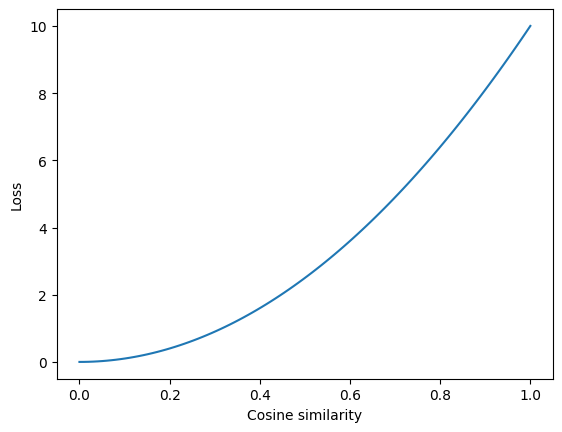

In [93]:
a = 10
x = torch.linspace(0, 1, 100)
z_dist_map = lambda x: a*x**2

plt.plot(x, z_dist_map(x))
plt.xlabel('Cosine similarity')
plt.ylabel('Loss')
plt.show()


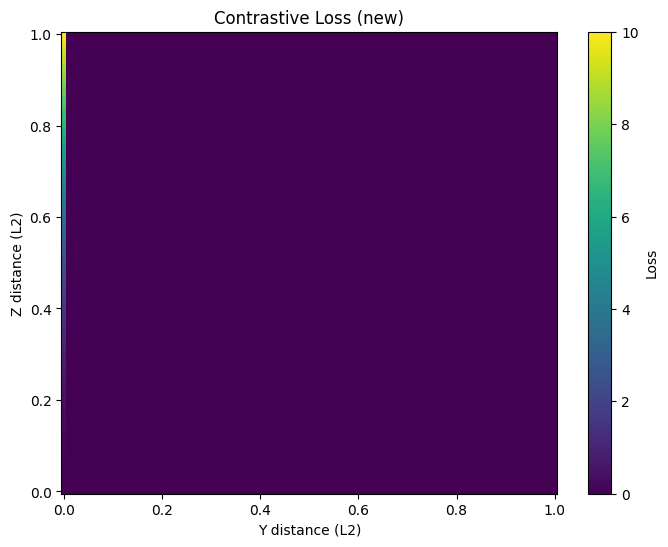

In [103]:
def contrastive_loss_new(z_dist, y_dist):
    a = 10

    threshold = lambda x: x < SIMILARITY_THRESHOLD
    z_dist_map = lambda x: a*x**2

    gamma = threshold(y_dist)
    loss_raw = z_dist_map(z_dist)
    loss = gamma * loss_raw
    return loss

# Create 2D histogram of contrastive loss
z_dist = torch.linspace(0, 1, 100)
y_dist = torch.linspace(0, 1, 100)
Z, Y = torch.meshgrid(z_dist, y_dist, indexing='xy')

# Calculate loss for each point
loss_grid = contrastive_loss_new(Z, Y)

plt.figure(figsize=(8, 6))
plt.pcolormesh(Y.numpy(), Z.numpy(), loss_grid.numpy(), shading='auto')
plt.colorbar(label='Loss')
plt.ylabel('Z distance (L2)')
plt.xlabel('Y distance (L2)')
plt.title('Contrastive Loss (new)')
plt.show()

### 1.3 Loss V3

In [15]:
similarity_mask = y_dist < SIMILARITY_THRESHOLD
~similarity_mask

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

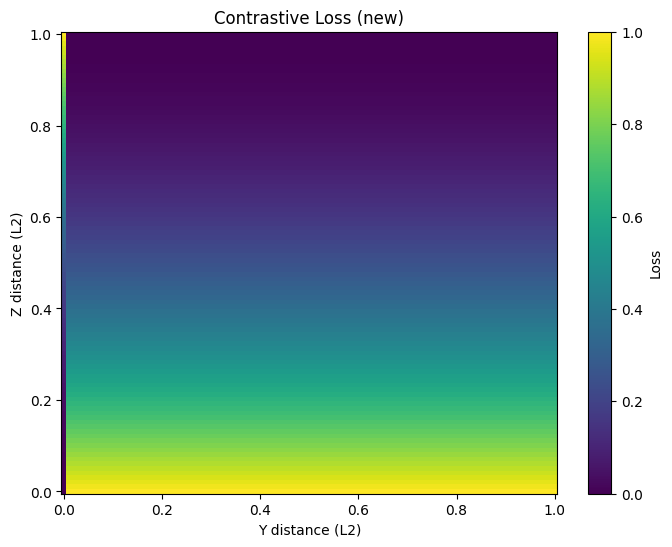

In [16]:
def contrastive_loss_V3(z_dist, y_dist):
    m = 1
    
    similarity_mask = y_dist < SIMILARITY_THRESHOLD
    loss = similarity_mask * z_dist**2 + (~similarity_mask) * torch.maximum(torch.tensor(0.0), m - z_dist)**2  # FIXME: Should this be sum or 
    return loss

# Create 2D histogram of contrastive loss
z_dist = torch.linspace(0, 1, 100)
y_dist = torch.linspace(0, 1, 100)  # MSE
Z, Y = torch.meshgrid(z_dist, y_dist, indexing='xy')

# Calculate loss for each point
loss_grid = contrastive_loss_V3(Z, Y)

plt.figure(figsize=(8, 6))
plt.pcolormesh(Y.numpy(), Z.numpy(), loss_grid.numpy(), shading='auto')
plt.colorbar(label='Loss')
plt.ylabel('Z distance (L2)')
plt.xlabel('Y distance (MSE)')
plt.title('Contrastive Loss (new)')
plt.show()

## 2. Contrastive loss with actual data

### 2.1 Load model, dataset and calculate distances for specific target

In [36]:
# Load model and dataset
model, cfg = load_wandb_model(run='n3gnm11h', name='last.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../model/config.yaml')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Imported model from run "n3gnm11h".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 8.9 M  | eval
1 | decoder       | Decoder      | 6.6 M  | eval
2 | value_decoder | ValueDecoder | 6.4 M  | eval
------------------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.677    Total estimated model params size (MB)
0         Modules in train mode
101       Modules in eval mode
Using dataset "dataset_241204_2" of size 1840811
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 1840811 | Batch: 512   | Batches: 3596 
  | valid        | Size: 204534  | Batch: 512   | Batches: 400  
---------------------------------------------------------------------


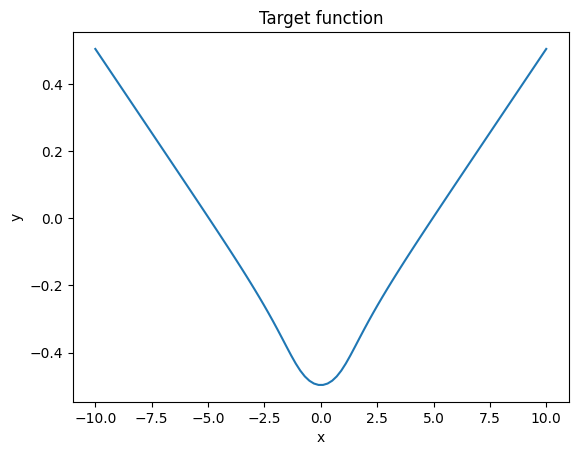

In [111]:
target_idx = 0
values_target = data_from_loader(train_loader, 'values', idx=target_idx)  
z_target = model.encoder(data_from_loader(train_loader, 'x', idx=target_idx))[0]

plt.plot(val_x.squeeze(), values_target.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [97]:
# Calculating z and y distances for all samples in training set (from sampling_analysis.ipynb)

N = 2**19
BATCH_SIZE = 2**15
N = (min(len(train_loader.dataset), N) // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size

values = data_from_loader(train_loader, 'values', max_length=N)

z_dist = torch.empty(N, 3)
for i, x in tqdm(enumerate(data_from_loader(train_loader, 'x', batch_size=BATCH_SIZE, max_length=N)), total=N//BATCH_SIZE, desc='Calculating z distances'):
    mean, ln_var = model.encoder(x)

    l2_dist = torch.norm(mean - z_target, dim=1)
    cos_sim = F.cosine_similarity(mean, z_target)
    dot_prod = torch.sum(mean * z_target, dim=1)
    
    z_dist[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.stack([l2_dist, cos_sim, dot_prod], dim=1)

y_dist = torch.mean((values - values_target)**2, dim=1)  # MSE

Calculating z distances: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


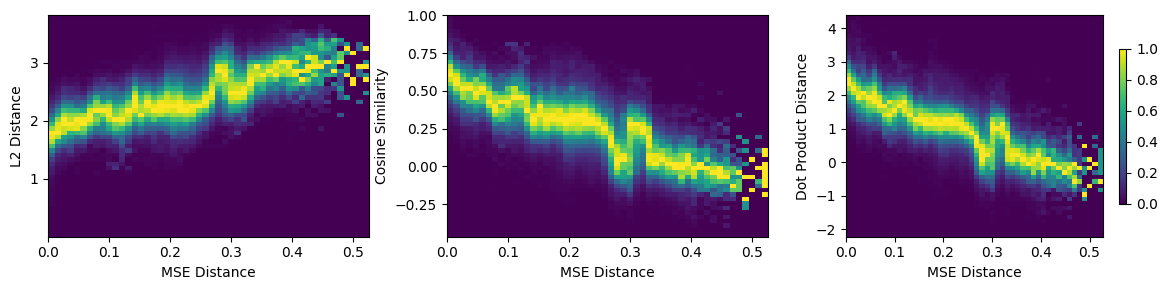

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# L2 Distance
h1, xedges, yedges, im1 = ax1.hist2d(y_dist.numpy(), z_dist[:, 0].numpy(), bins=50, cmap='viridis')
h1 = h1 / h1.max(axis=1, keepdims=True)  # Normalize each column
im1.set_array(h1.T)
im1.set_clim(0, h1.max())  # Set colormap range from 0 to 1
ax1.set_xlabel('MSE Distance')
ax1.set_ylabel('L2 Distance')

# Cosine Similarity 
h2, xedges, yedges, im2 = ax2.hist2d(y_dist.numpy(), z_dist[:, 1].numpy(), bins=50, cmap='viridis')
h2 = h2 / h2.max(axis=1, keepdims=True)  # Normalize each column
im2.set_array(h2.T)
im2.set_clim(0, h2.max())  # Set colormap range from 0 to 1
ax2.set_xlabel('MSE Distance')
ax2.set_ylabel('Cosine Similarity')

# Dot Product
h3, xedges, yedges, im3 = ax3.hist2d(y_dist.numpy(), z_dist[:, 2].numpy(), bins=50, cmap='viridis')
h3 = h3 / h3.max(axis=1, keepdims=True)  # Normalize each column
im3.set_array(h3.T)
im3.set_clim(0, h3.max())  # Set colormap range from 0 to 1
plt.colorbar(im3, shrink=0.7)
ax3.set_xlabel('MSE Distance')
ax3.set_ylabel('Dot Product Distance')

plt.tight_layout()

### 2.2 Calculate contrastive losses

In [100]:
loss = contrastive_loss_new(z_dist[:, 0], y_dist)

In [101]:
loss.shape

torch.Size([524288])

### 2.3 Implementation for model

In [119]:
batch_size = 100
num_points = 100
z_size = 32
z_slice = (0, 31)

y_val = torch.randn(batch_size, num_points)
z = torch.randn(batch_size, z_size)

l2_dist = torch.nn.PairwiseDistance(p=2)


SIMILARITY_THRESHOLD = 1e-3

values_dist = l2_dist(y_val.unsqueeze(1), y_val.unsqueeze(0))
similarity_mask = values_dist < SIMILARITY_THRESHOLD
u = z[:, z_slice[0]:z_slice[1]]
u_dist = l2_dist(u.unsqueeze(1), u.unsqueeze(0))
u_dissim_loss = u_dist**2
loss_contrastive = torch.sum(similarity_mask * u_dissim_loss)
loss_contrastive

tensor(3.1000e-09)

### 2.4 Plot relation between different z distances

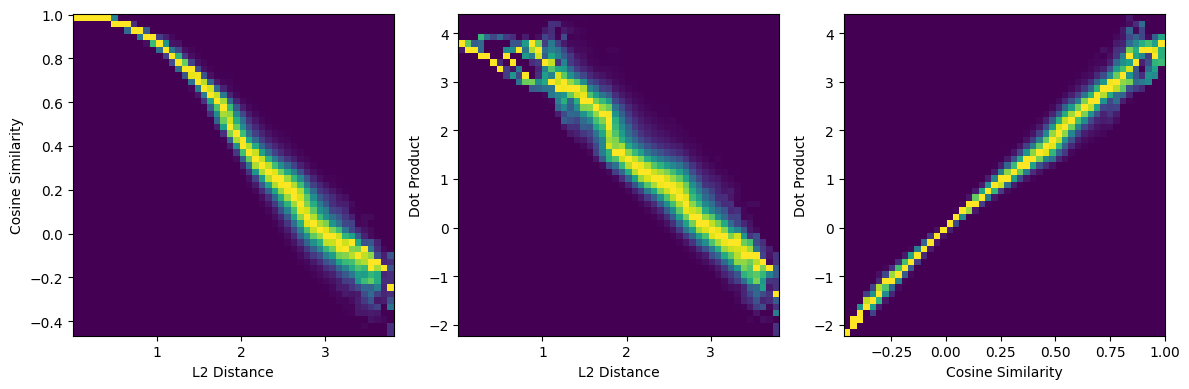

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# L2 vs Cosine
h1, xedges, yedges, im1 = ax1.hist2d(z_dist[:, 0], z_dist[:, 1], bins=50, cmap='viridis')
h1 = h1 / h1.max(axis=1, keepdims=True)  # Normalize each column
im1.set_array(h1.T)
im1.set_clim(0, h1.max())  # Set colormap range from 0 to 1
ax1.set_xlabel('L2 Distance')
ax1.set_ylabel('Cosine Similarity')

# L2 vs Dot Product
h2, xedges, yedges, im2 = ax2.hist2d(z_dist[:, 0], z_dist[:, 2], bins=50, cmap='viridis')
h2 = h2 / h2.max(axis=1, keepdims=True)  # Normalize each column
im2.set_array(h2.T)
im2.set_clim(0, h2.max())  # Set colormap range from 0 to 1
ax2.set_xlabel('L2 Distance')
ax2.set_ylabel('Dot Product')

# Cosine vs Dot Product
h3, xedges, yedges, im3 = ax3.hist2d(z_dist[:, 1], z_dist[:, 2], bins=50, cmap='viridis')
h3 = h3 / h3.max(axis=1, keepdims=True)  # Normalize each column
im3.set_array(h3.T)
im3.set_clim(0, h3.max())  # Set colormap range from 0 to 1
ax3.set_xlabel('Cosine Similarity')
ax3.set_ylabel('Dot Product')

plt.tight_layout()

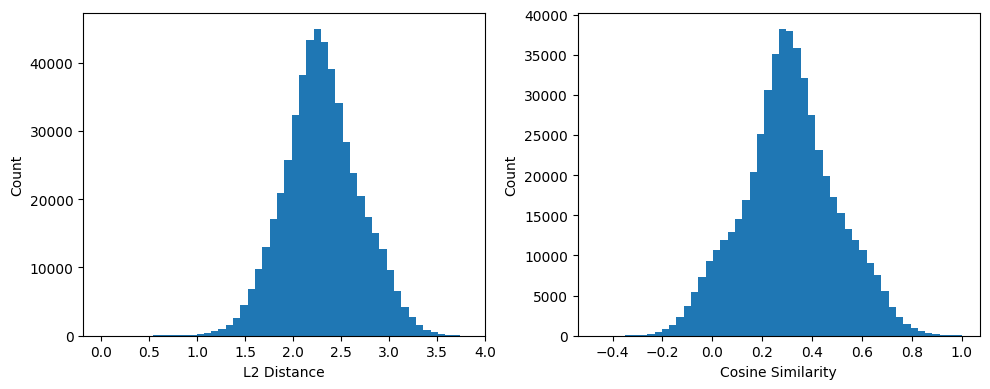

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot L2 distance histogram
ax1.hist(z_dist[:, 0], bins=50)
ax1.set_xlabel('L2 Distance')
ax1.set_ylabel('Count')

# Plot cosine similarity histogram 
ax2.hist(z_dist[:, 1], bins=50)
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

## Old stuff

In [ ]:
l2_dist = torch.nn.PairwiseDistance(p=2)
a = 40  # Sharpness
b = 5  # Shift
gamma_func = lambda x: 1/(1+ torch.exp(a * x - b))


y_values = y_values / y_values.norm(dim=1, keepdim=True)
values_dist = l2_dist(y_values.unsqueeze(1), y_values.unsqueeze(0))  # Make this indep of z_size, add some scaling factor
similarity_mask = gamma_func(values_dist.square())  # Scaling factor: Only if graphs are similar should large z_dissim be penalized


z_sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # -> 1 if similar, 0 if unrelated, -> -1 if different
z_dissim_loss = -torch.log((1+z_sim)/2)  # -> 1 if different, 0 if similar, -> 2 if unrelated
loss = torch.sum(similarity_mask * z_dissim_loss)

NameError: name 'y_values' is not defined

In [ ]:
from torch.nn import functional as F
import torch

x = data_from_loader(train_loader, 'x', range(128))
y_values = data_from_loader(train_loader, 'values', range(128))

l2_dist = torch.nn.PairwiseDistance(p=2)


mean, ln_var = model.encoder(x)
z = model.sample(mean, ln_var)

# -> 0 if similar, -> inf if different
y_values = y_values / y_values.norm(dim=1, keepdim=True)
values_dist = l2_dist(y_values.unsqueeze(1), y_values.unsqueeze(0))  # Make this indep of z_size, add some scaling factor

z_sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # -> 1 if similar, 0 if unrelated, -> -1 if different


In [ ]:
z_dissim_loss = -torch.log((1+z_sim)/2)  # -> 1 if different, 0 if similar, -> 2 if unrelated
z_dissim_loss[:5, :5]

tensor([[-0.0000, 0.6998, 0.8065, 0.9421, 0.7715],
        [0.6998, -0.0000, 0.5427, 0.7679, 0.6305],
        [0.8065, 0.5427, -0.0000, 1.1608, 0.8583],
        [0.9421, 0.7679, 1.1608, -0.0000, 0.3494],
        [0.7715, 0.6305, 0.8583, 0.3494, -0.0000]])

In [ ]:
z_dissim_loss.max()

tensor(1.4750)

In [ ]:
a = 40  # Sharpness
b = 5  # Shift

gamma_func = lambda x: 1/(1+ torch.exp(a * x - b))

similarity_mask = gamma_func(values_dist.square())  # Scaling factor

loss = similarity_mask * z_dissim_loss

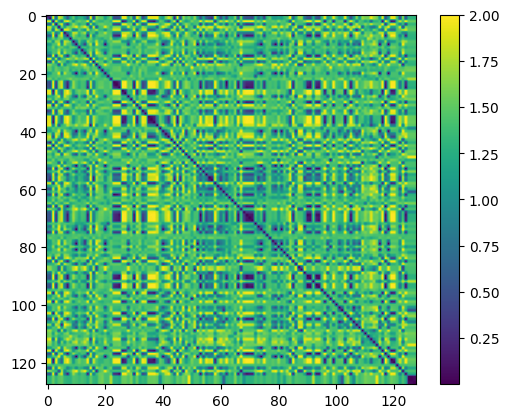

In [ ]:
plt.imshow(values_dist.T)
plt.colorbar()
plt.show()

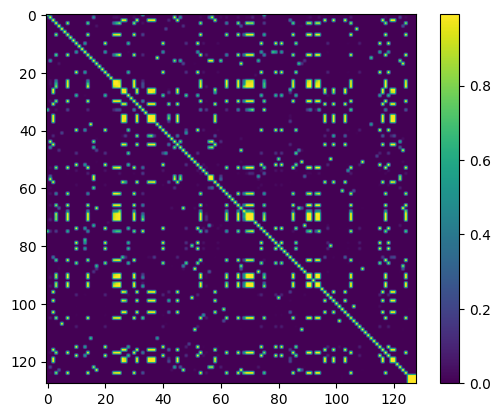

In [ ]:
plt.imshow(similarity_mask.T)
plt.colorbar()
plt.show()

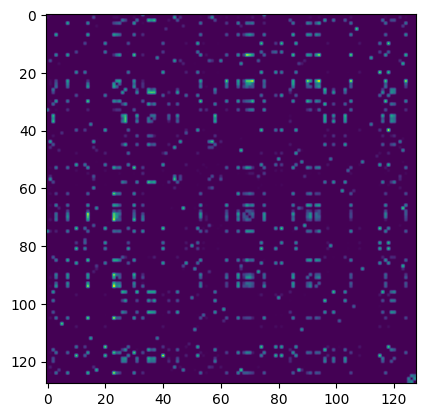

In [ ]:
plt.imshow(loss.T)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Function to get random pairs of indices
def get_random_pairs(n, size):
    return torch.randint(0, size, (n, 2))

# Get 16 random pairs
num_pairs = 16
total_samples = values_dist.shape[0]
pairs = get_random_pairs(num_pairs, total_samples)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Random Pairs Analysis", fontsize=16)

for idx, (i, j) in enumerate(pairs):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    # Extract values for the pair
    dist = values_dist[i, j].item()
    gam = similarity_mask[i, j].item()
    sim = z_sim[i, j].item()
    dissim = z_dissim_loss[i, j].item()
    loss_val = loss[i, j].item()
    
    # Calculate cosine similarity between y values
    y_sim = F.cosine_similarity(y_values[i].unsqueeze(0), y_values[j].unsqueeze(0), dim=1).item()
    
    # Create a text box with the values
    textstr = f'values_dist: {dist:.4f}\ngamma: {gam:.4f}\nz_sim: {sim:.4f}\nz_dissim_loss: {dissim:.4f}\nloss: {loss_val:.4f}\n'
    # y_sim: {y_sim:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Plot y_values for the pair
    x = np.arange(len(y_values[i]))
    ax.plot(x, y_values[i].cpu().numpy(), label='Sample 1')
    ax.plot(x, y_values[j].cpu().numpy(), label='Sample 2')
    ax.legend(fontsize='small')
    
    # Set axis labels
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_title(f'Pair {idx+1}')

plt.tight_layout()
plt.show()


NameError: name 'values_dist' is not defined